In [40]:
from pymatgen.core import Structure
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [29]:
from mofdscribe.featurizers.chemistry._fragment import get_bb_indices
from mofdscribe.featurizers.chemistry._fragment import get_bbs_from_indices
from structuregraph_helpers.subgraph import get_subgraphs_as_molecules
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.io.cif import CifWriter
import re
from pymatgen.analysis.local_env import CutOffDictNN
import yaml

from mofgraph2vec.featurize.mof2doc import MOF2doc

with open("../src/mofgraph2vec/featurize/tuned_vesta.yml", "r", encoding="utf8") as handle:
    _VESTA_CUTOFFS = yaml.load(handle, Loader=yaml.UnsafeLoader) 

import warnings
from collections import defaultdict
from typing import List, Tuple

import networkx as nx
import numpy as np
from pymatgen.analysis.graphs import MoleculeGraph, StructureGraph
from pymatgen.core import Element, Molecule, Structure

from copy import deepcopy
from typing import Dict, List, Set

from pymatgen.analysis.graphs import StructureGraph
from pymatgen.core import Structure
from structuregraph_helpers.subgraph import get_subgraphs_as_molecules

from mofdscribe.featurizers.utils.structure_graph import get_connected_site_indices
from mofdscribe.featurizers.utils.substructures import (
    _not_relevant_structure_indices,
    get_metal_indices,
)

from structuregraph_helpers.subgraph import _get_mass

In [22]:
cif = Structure.from_file("../data/cifs/rsm/RSM0003.cif")
sg = StructureGraph.with_local_env_strategy(cif, CutOffDictNN(cut_off_dict=_VESTA_CUTOFFS))

In [23]:
indices = get_bb_indices(sg) 

In [24]:
indices

{'linker_all': [[0, 8, 6, 3], [2, 10, 5, 7], [4, 9, 1, 11]],
 'linker_functional': [[0]],
 'linker_scaffold': [[6, 3], [2, 5], [4, 1]],
 'linker_connecting': [[8], [10, 7], [9, 11]],
 'nodes': [[0]]}

In [19]:
from torch_geometric.data import Data

In [42]:
data = Data(
    x=['O' 'C', 'Zn'], 
    num_nodes = 3, 
    edge_index=torch.LongTensor([[1], [2]]), 
    nodes=[1], 
            )

In [21]:
torch.save(data, "./test/tmp/test.pt")

In [36]:
from torch_geometric.utils import to_networkx


In [43]:
graph = to_networkx(data)

In [45]:
for node in graph.nodes:
    if node in [2, 3]:
        print(node)

2


In [5]:
indices.keys()

dict_keys(['linker_all', 'linker_functional', 'linker_scaffold', 'linker_connecting', 'nodes'])

In [6]:
def get_subs_from_indices(structure_graph: StructureGraph, indices: Set[int]):
    graph_ = structure_graph.__copy__()
    graph_.structure = Structure.from_sites(graph_.structure.sites)
    to_delete = _not_relevant_structure_indices(graph_.structure, indices)
    assert len(structure_graph) == len(to_delete) + len(indices)
    graph_.remove_nodes(to_delete)
    return graph_


In [11]:
indices.keys()

dict_keys(['linker_all', 'linker_functional', 'linker_scaffold', 'linker_connecting', 'nodes'])

In [18]:
task = "nodes"
subgraph = get_subs_from_indices(sg, [item for sublist in indices[task] for item in sublist])
CifWriter(subgraph.structure, symprec=None, write_magmoms=False, significant_figures=8, angle_tolerance=5.0, refine_struct=True).write_file("test/tmp/%s_rsm.cif" %task)

In [34]:
_, subgraph, _, _, _ = get_bbs_from_indices(sg, [item for sublist in indices["linker_all"] for item in sublist])

/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/structuregraph_helpers/subgraph.py:121: UserWarning: No node attributes found. Using indices as node attributes.
  warnings.warn("No node attributes found. Using indices as node attributes.")


In [78]:
data_loader = MOF2doc(
    cif_path=["./"],
    wl_step=2,
    n_components=20,
    use_hash=False,
    writing_style="paragraph",
    composition=False,
)

In [79]:
data_loader.get_documents()

100%|██████████| 7/7 [00:00<00:00, 25.12it/s]


[TaggedDocument(words=['Zn_O_O_O_O', 'Zn_O_O', 'O_Zn_Zn_Zn_Zn', 'O_Zn', 'Zn_O_O_O_O_O_Zn_O_Zn_O_Zn_O_Zn_Zn_Zn_Zn', 'Zn_O_O_O_Zn_O_Zn_Zn_Zn_Zn', 'O_Zn_Zn_Zn_Zn_Zn_O_O_O_O_Zn_O_O_O_O_Zn_O_O_O_O_Zn_O_O_O_O', 'O_Zn_Zn_Zn_Zn_Zn_O_O_Zn_O_O_Zn_O_O_Zn_O_O', 'O_Zn_Zn_O_O_O_O', 'O_Zn_Zn_O_O'], tags=['linker']),
 TaggedDocument(words=['O', 'O'], tags=['linker_connecting']),
 TaggedDocument(words=['H_C', 'C_C', 'C_C_C_C', 'C_C_C_H', 'H_C_C_C_C_H', 'C_C_C_C_C_C', 'C_C_C_C_C_C_C_C_C_H_C_C_C_H', 'C_C_C_H_C_C_C_C_C_C_C_H_H_C'], tags=['linker_scaffold']),
 TaggedDocument(words=['Zn', 'Zn'], tags=['nodes']),
 TaggedDocument(words=['Zn', 'Zn'], tags=['linker_functional']),
 TaggedDocument(words=['Zn_O_O_O_O', 'H_C', 'C_C_O_O', 'C_C_C_C', 'C_C_C_H', 'O_Zn_Zn_Zn_Zn', 'O_C_Zn', 'Zn_O_O_O_O_O_C_Zn_O_C_Zn_O_C_Zn_O_Zn_Zn_Zn_Zn', 'H_C_C_C_C_H', 'C_C_O_O_C_C_C_C_O_C_Zn_O_C_Zn', 'C_C_C_C_C_C_C_H_C_C_C_H_C_C_O_O', 'C_C_C_H_C_C_C_C_C_C_C_H_H_C', 'O_Zn_Zn_Zn_Zn_Zn_O_O_O_O_Zn_O_O_O_O_Zn_O_O_O_O_Zn_O_O_O_O', 'O_C_Zn_C

In [208]:
cif.formula

'Zn8 H24 C48 O26'

In [28]:
len(sub_linker.structure.sites)

98

In [24]:
len(cif.sites)

106

In [21]:
[x for x in np.unique(py_strucs[0].species) if x.is_metal]

[Element Fe]

In [22]:
df = pd.read_csv("../data/data.csv")

In [25]:
py_strucs = [Structure.from_file("../data/cifs/rsm/%s.cif" %c) for c in tqdm(df["cif.label"])]

  0%|          | 3/3257 [00:00<02:18, 23.58it/s]/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pymatgen/io/cif.py:1147: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
100%|██████████| 3257/3257 [01:37<00:00, 33.54it/s]


In [30]:
metal_list = [[x.symbol for x in np.unique(struc.species) if x.is_metal] for struc in tqdm(py_strucs)]

100%|██████████| 3257/3257 [00:08<00:00, 365.11it/s]


In [31]:
for x in metal_list:
    if len(x) != 1:
        print(x)

['Gd', 'Ag']
['Cu', 'W']
['Al', 'Ag']
['Gd', 'Co']
['Cd', 'Ni']
['Na', 'Cd']
['Cu', 'Mo']
['K', 'La']
['K', 'Ce']
['Na', 'Zn']
['K', 'Zn']
['Cd', 'Ni']
['Cu', 'W']
['Tb', 'Cu']
['Mn', 'Fe']
['K', 'Sc']
['Cu', 'Mo']
['Cu', 'W']
['Zn', 'Co']
['Ca', 'Pb']
['Mn', 'Cu']
['Li', 'Zn']
['Lu', 'W']
['Na', 'Zn']
['Rb', 'Co']
['Ba', 'Cd']
['Na', 'Co']
['Zn', 'Cu']
['Zn', 'Co']
['K', 'Ni']
['Fe', 'Ni']
['Cu', 'Mo']
['Cu', 'Mo']
['La', 'Co']
['Ni', 'W']
['Ni', 'Mo']
['La', 'Cu']
['Ca', 'Cd']
['Ni', 'Mo']
['Ho', 'Cu']
['Na', 'Tb']
['La', 'Mg']
['Mn', 'Cu']
['Mn', 'Co']
['Eu', 'W']
['Ba', 'Cu']
['Gd', 'Ag']
['Cu', 'W']
['Mn', 'Cr', 'Fe']
['Cu', 'W']
['Sr', 'Zn']
['Sr', 'Ni']
['La', 'Eu']
['Ca', 'Ce']
['Ba', 'Zn']
['Ba', 'Co']
['Cu', 'W']
['Tb', 'Eu']
['Ni', 'Mo']
['Tb', 'Cu']
['Tb', 'Cu']
['Sm', 'Zn']
['Na', 'Zn', 'Co']
['Eu', 'Ag']
['Ce', 'Mg']
['Nb', 'Cu']
['Na', 'Zn']
['Na', 'Zn', 'Fe']
['Mg', 'Cd', 'Mo']
['Mn', 'Au']
['Mn', 'Ag']
['La', 'Ni']
['K', 'Fe', 'Ni']
['Co', 'Cu']
['Sr', 'U']
['Na', 'Co'

In [32]:
df["metal_1"] = [ele[0] for ele in metal_list]

In [36]:
metal_2 = [ele[1] if len(ele)>1 else np.NaN for ele in metal_list]

In [44]:
metal_3 = [ele[2] if len(ele)>2 else np.NaN for ele in metal_list]

In [45]:
metal_4 = [ele[3] if len(ele)>3 else np.NaN for ele in metal_list]

In [43]:
df["metal_2"] = metal_2

In [46]:
df["metal_3"] = metal_3

In [47]:
df["metal_4"] = metal_4

In [49]:
df.loc[:, ~df.columns.str.match('Unnamed: 0')]

,in,ASA [m^2/cm^3],CellV [A^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],...,KH_N2_molkgpa,log_selectivity,info.decorated_graph_hash,info.undecorated_graph_hash,info.decorated_scaffold_hash,info.undecorated_scaffold_hash,metal_1,metal_2,metal_3,metal_4
0,8,2163.580,20019.00,7.83744,9.47418,9.45292,0.000000,1.074720,0.64186,0.000000,...,4.160970e-06,0.449093,382517780dc5ab8eb8fa43295ce8bdf4,b49059acbd8c344ef658b5b181a142f5,25800f339ff3d43d2ddc5d1a59b4eeb4,08515bc3d51c5d80eafef0baa6e2b134,Cu,NaN,NaN,NaN
1,9,641.266,2633.04,4.14331,4.82084,4.80387,0.000000,0.136436,0.24024,0.000000,...,7.416090e-08,NaN,a84c197bbfa5810808c44dc4ccfe11af,874ad4e1f85e1de8bd54bed65199e13a,b526ee2136f2d05af53b2bed85c5339d,b02ed13751c7be6d0f820f3e5f81b9b3,La,NaN,NaN,NaN
2,10,1603.800,15518.00,13.71867,18.80790,18.79960,0.888134,0.957188,0.64550,0.000000,...,6.027810e-06,0.533550,45efa7c1e878af5ecbc618b706fc1136,bccd7095b8e6d26f8257ae674095d645,13cae2b9e4cfe2cfe9d05a9468ae4830,eb2900477384511abd851c626625231e,In,NaN,NaN,NaN
3,11,600.107,2602.59,4.06893,4.80529,4.80529,0.000000,0.133609,0.23884,0.000000,...,1.174370e-06,0.522879,67abee315179d34012433698bf59a924,9fa41a3543983b720923f5ffb080b005,57a7b96939ec88db393126c63b0ed48d,0a8666fb6118b8149daf8d5e89321c93,Ce,NaN,NaN,NaN
4,15,498.734,2493.02,3.94356,4.70447,4.68752,0.000000,0.113502,0.21898,0.000000,...,1.454260e-06,0.548749,3f69a0844ce43a2c27086353118d05ed,44a150af84481dfe02a60f89af03568c,8cd5110f581b241624b3544555208c56,9be47b63130f6c51d0ab9c1bf63e789e,Eu,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,9677,601.756,4479.64,4.08689,4.75984,4.75984,0.000000,0.163833,0.25402,0.000000,...,3.365250e-06,0.868569,df97f8d55b270ccf87d6b5ef1d240b49,b9fbb38978dc92454d5f9dadc2d1f889,b7ce948b3839045aeca55c2b2b8c5831,04093fb5811c815186f3c99d9bf510d0,Cd,NaN,NaN,NaN
3253,9679,1607.600,2134.77,7.69493,9.54888,9.54888,0.000000,0.661485,0.57334,0.000000,...,3.589710e-06,0.509364,bcd37c930e2b58a516766833377a8c77,d7f19b4984eefc1dfe81e7e5d11a2c3c,3363bfcc7baaa3e433d11644fc5fa6ee,4cd3ef34cda4fc1a43dccccec19778b1,Zn,NaN,NaN,NaN
3254,9681,416.131,1636.02,4.20115,4.73990,4.72096,0.000000,0.093092,0.16366,0.000000,...,7.976930e-06,1.153723,f5a545a2d506d8424bfbbfd2917b9b9b,006d95bcc7ab668a21894bcb66e6b445,5a0a0630fef8a2bafe333d8fe4388354,ba67a8fe5b11dba57bc563a5d3b7a543,Zn,NaN,NaN,NaN
3255,9685,0.000,2044.51,2.56035,4.18124,4.16282,35.643400,0.000000,0.00000,0.024759,...,3.393710e-06,NaN,47335f2329fe60935ca636a63a0ebd48,70e36dc2a0dd36e20a761769501aa3f9,f0900a12ad6d994e6c6a490cedc50406,55501fe2ad68169f472605c0ab6f6cd2,K,Gd,NaN,NaN


In [50]:
df.to_csv("../data/rsm_metal.csv", index=False)

In [18]:
df = pd.read_csv("../data/data.csv").set_index("cif.label")

In [20]:
names = [
    'CellV [A^3]',
    'Di',
    'Df',
    'Dif',
    'density [g/cm^3]',
    'total_SA_volumetric',
    'total_SA_gravimetric',
    'total_POV_volumetric',
    'total_POV_gravimetric'
]

In [26]:
linker_descriptors = [
 'f-lig-chi-0',
 'f-lig-chi-1',
 'f-lig-chi-2',
 'f-lig-chi-3',
 'f-lig-Z-0',
 'f-lig-Z-1',
 'f-lig-Z-2',
 'f-lig-Z-3',
 'f-lig-I-0',
 'f-lig-I-1',
 'f-lig-I-2',
 'f-lig-I-3',
 'f-lig-T-0',
 'f-lig-T-1',
 'f-lig-T-2',
 'f-lig-T-3',
 'f-lig-S-0',
 'f-lig-S-1',
 'f-lig-S-2',
 'f-lig-S-3',
 'lc-chi-0-all',
 'lc-chi-1-all',
 'lc-chi-2-all',
 'lc-chi-3-all',
 'lc-Z-0-all',
 'lc-Z-1-all',
 'lc-Z-2-all',
 'lc-Z-3-all',
 'lc-I-0-all',
 'lc-I-1-all',
 'lc-I-2-all',
 'lc-I-3-all',
 'lc-T-0-all',
 'lc-T-1-all',
 'lc-T-2-all',
 'lc-T-3-all',
 'lc-S-0-all',
 'lc-S-1-all',
 'lc-S-2-all',
 'lc-S-3-all',
 'lc-alpha-0-all',
 'lc-alpha-1-all',
 'lc-alpha-2-all',
 'lc-alpha-3-all',
 'D_lc-chi-0-all',
 'D_lc-chi-1-all',
 'D_lc-chi-2-all',
 'D_lc-chi-3-all',
 'D_lc-Z-0-all',
 'D_lc-Z-1-all',
 'D_lc-Z-2-all',
 'D_lc-Z-3-all',
 'D_lc-I-0-all',
 'D_lc-I-1-all',
 'D_lc-I-2-all',
 'D_lc-I-3-all',
 'D_lc-T-0-all',
 'D_lc-T-1-all',
 'D_lc-T-2-all',
 'D_lc-T-3-all',
 'D_lc-S-0-all',
 'D_lc-S-1-all',
 'D_lc-S-2-all',
 'D_lc-S-3-all',
 'D_lc-alpha-0-all',
 'D_lc-alpha-1-all',
 'D_lc-alpha-2-all',
 'D_lc-alpha-3-all']

metalcenter_descriptors =[
 'mc_CRY-chi-0-all',
 'mc_CRY-chi-1-all',
 'mc_CRY-chi-2-all',
 'mc_CRY-chi-3-all',
 'mc_CRY-Z-0-all',
 'mc_CRY-Z-1-all',
 'mc_CRY-Z-2-all',
 'mc_CRY-Z-3-all',
 'mc_CRY-I-0-all',
 'mc_CRY-I-1-all',
 'mc_CRY-I-2-all',
 'mc_CRY-I-3-all',
 'mc_CRY-T-0-all',
 'mc_CRY-T-1-all',
 'mc_CRY-T-2-all',
 'mc_CRY-T-3-all',
 'mc_CRY-S-0-all',
 'mc_CRY-S-1-all',
 'mc_CRY-S-2-all',
 'mc_CRY-S-3-all',
 'D_mc_CRY-chi-0-all',
 'D_mc_CRY-chi-1-all',
 'D_mc_CRY-chi-2-all',
 'D_mc_CRY-chi-3-all',
 'D_mc_CRY-Z-0-all',
 'D_mc_CRY-Z-1-all',
 'D_mc_CRY-Z-2-all',
 'D_mc_CRY-Z-3-all',
 'D_mc_CRY-I-0-all',
 'D_mc_CRY-I-1-all',
 'D_mc_CRY-I-2-all',
 'D_mc_CRY-I-3-all',
 'D_mc_CRY-T-0-all',
 'D_mc_CRY-T-1-all',
 'D_mc_CRY-T-2-all',
 'D_mc_CRY-T-3-all',
 'D_mc_CRY-S-0-all',
 'D_mc_CRY-S-1-all',
 'D_mc_CRY-S-2-all',
 'D_mc_CRY-S-3-all']

functionalgroup_descriptors = [
 'func-chi-0-all',
 'func-chi-1-all',
 'func-chi-2-all',
 'func-chi-3-all',
 'func-Z-0-all',
 'func-Z-1-all',
 'func-Z-2-all',
 'func-Z-3-all',
 'func-I-0-all',
 'func-I-1-all',
 'func-I-2-all',
 'func-I-3-all',
 'func-T-0-all',
 'func-T-1-all',
 'func-T-2-all',
 'func-T-3-all',
 'func-S-0-all',
 'func-S-1-all',
 'func-S-2-all',
 'func-S-3-all',
 'func-alpha-0-all',
 'func-alpha-1-all',
 'func-alpha-2-all',
 'func-alpha-3-all',
 'D_func-chi-0-all',
 'D_func-chi-1-all',
 'D_func-chi-2-all',
 'D_func-chi-3-all',
 'D_func-Z-0-all',
 'D_func-Z-1-all',
 'D_func-Z-2-all',
 'D_func-Z-3-all',
 'D_func-I-0-all',
 'D_func-I-1-all',
 'D_func-I-2-all',
 'D_func-I-3-all',
 'D_func-T-0-all',
 'D_func-T-1-all',
 'D_func-T-2-all',
 'D_func-T-3-all',
 'D_func-S-0-all',
 'D_func-S-1-all',
 'D_func-S-2-all',
 'D_func-S-3-all',
 'D_func-alpha-0-all',
 'D_func-alpha-1-all',
 'D_func-alpha-2-all',
 'D_func-alpha-3-all']

RACs = metalcenter_descriptors + linker_descriptors + functionalgroup_descriptors

In [22]:
df_struc = df[names]

In [27]:
df_racs = df[RACs]

In [28]:
df_racs = df_racs.rename(index={"cif.label": "type"})

In [30]:
df_racs.to_csv("../data/features/RSM/RACs.csv")

In [3]:
df_emb = pd.read_csv("../experiments/workflow/wandb/offline-run-20230523_190357-93u4mjhz/tmp/embedding_dv.csv").set_index("type")

In [11]:
df_sto = pd.read_csv("../data/embedding_example/rsm-sto120.csv").set_index("type")

In [13]:
df_com = df_emb.join(df_sto)

In [14]:
df_com

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,range Electronegativity,mean Electronegativity,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
type,,,,,,,,,,,,,,,,,,,,,
RSM0001,0.101371,0.215530,0.033499,-0.141782,0.005453,0.175517,-0.077258,-0.087504,-0.009211,0.037494,...,2.240,2.776154,1.769231,2.307692,0.076923,0.538462,0.377049,0.491803,0.016393,0.114754
RSM0002,0.170878,0.339871,0.004684,-0.179333,-0.039081,0.375669,-0.173313,-0.155345,-0.082482,0.004756,...,2.270,2.773846,1.769231,2.307692,0.000000,0.461538,0.389831,0.508475,0.000000,0.101695
RSM0003,0.130742,0.187140,0.008065,-0.247930,-0.052194,0.381775,-0.115752,-0.149821,-0.014116,0.007495,...,2.230,2.776923,1.769231,2.307692,0.000000,0.692308,0.370968,0.483871,0.000000,0.145161
RSM0004,0.130990,0.293535,-0.022066,-0.178386,0.008399,0.325342,-0.112160,-0.126959,-0.022916,-0.059256,...,2.255,2.775000,1.769231,2.307692,0.000000,0.538462,0.383333,0.500000,0.000000,0.116667
RSM0008,0.072972,0.150865,0.030419,-0.113763,0.068517,0.171237,-0.002723,0.008092,0.002610,0.049884,...,2.130,2.729091,1.909091,2.363636,0.000000,0.000000,0.446809,0.553191,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RSM4610,0.039640,0.344323,0.157458,-0.120436,-0.020549,0.705851,-0.560834,0.038037,-0.446579,0.162828,...,1.790,2.470651,1.587455,1.319662,0.349819,0.000000,0.487407,0.405185,0.107407,0.000000
RSM4613,-0.094842,0.157643,0.098664,0.049347,0.162792,0.177498,-0.316448,-0.048457,-0.102722,-0.012007,...,1.790,2.510426,1.617021,1.446809,0.212766,0.000000,0.493506,0.441558,0.064935,0.000000
RSM4614,-0.013330,0.037651,-0.021806,0.047638,0.050852,0.188703,-0.000857,-0.094424,-0.069792,0.055648,...,1.540,2.547222,1.694444,1.638889,0.277778,0.000000,0.469231,0.453846,0.076923,0.000000


In [15]:
df_com.to_csv("../data/embedding_example/rsm_sto120_mof2vec.csv")

In [77]:
df_combin = df_emb.join(df_sto_mean)

In [78]:
df_combin

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,MatscholarElementData mean embedding 191,MatscholarElementData mean embedding 192,MatscholarElementData mean embedding 193,MatscholarElementData mean embedding 194,MatscholarElementData mean embedding 195,MatscholarElementData mean embedding 196,MatscholarElementData mean embedding 197,MatscholarElementData mean embedding 198,MatscholarElementData mean embedding 199,MatscholarElementData mean embedding 200
type,,,,,,,,,,,,,,,,,,,,,
RSM0001,0.101371,0.215530,0.033499,-0.141782,0.005453,0.175517,-0.077258,-0.087504,-0.009211,0.037494,...,0.119388,-0.040717,-0.033272,-0.054816,-0.004912,0.015728,-0.003543,0.054782,-0.002767,0.024165
RSM0002,0.170878,0.339871,0.004684,-0.179333,-0.039081,0.375669,-0.173313,-0.155345,-0.082482,0.004756,...,0.121532,-0.041453,-0.034330,-0.056544,-0.004094,0.021566,-0.005489,0.056697,-0.002465,0.022273
RSM0003,0.130742,0.187140,0.008065,-0.247930,-0.052194,0.381775,-0.115752,-0.149821,-0.014116,0.007495,...,0.121614,-0.047928,-0.031848,-0.055058,-0.004176,0.014536,-0.000956,0.053780,-0.000682,0.018945
RSM0004,0.130990,0.293535,-0.022066,-0.178386,0.008399,0.325342,-0.112160,-0.126959,-0.022916,-0.059256,...,0.120118,-0.044087,-0.034217,-0.059996,-0.002523,0.021942,0.001433,0.057742,-0.005464,0.019835
RSM0008,0.072972,0.150865,0.030419,-0.113763,0.068517,0.171237,-0.002723,0.008092,0.002610,0.049884,...,0.107734,-0.036597,-0.018737,-0.057656,0.008754,-0.001519,0.019139,0.053759,-0.022151,0.026957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RSM4610,0.039640,0.344323,0.157458,-0.120436,-0.020549,0.705851,-0.560834,0.038037,-0.446579,0.162828,...,0.121005,-0.044259,-0.026141,-0.029223,-0.011680,-0.020062,0.017488,0.047380,0.007716,0.032073
RSM4613,-0.094842,0.157643,0.098664,0.049347,0.162792,0.177498,-0.316448,-0.048457,-0.102722,-0.012007,...,0.122189,-0.044788,-0.025178,-0.032462,-0.007945,-0.019158,0.019006,0.044053,0.004590,0.034380
RSM4614,-0.013330,0.037651,-0.021806,0.047638,0.050852,0.188703,-0.000857,-0.094424,-0.069792,0.055648,...,0.115618,-0.043455,-0.017459,-0.038193,-0.000930,-0.024042,0.027288,0.043123,-0.003907,0.034360


In [80]:
df_combin = df_combin.join(df_label[["logKH_CH4", "logKH_CO2"]])

In [81]:
df_train, df_test = train_test_split(df_combin, test_size=0.2)

In [82]:
df_train.to_csv("/Users/xiaoqi/Codes/candidacy/database/rsm_composition_mof2vec_train.csv")

In [83]:
df_test.to_csv("/Users/xiaoqi/Codes/candidacy/database/rsm_composition_mof2vec_test.csv")

In [31]:
df_geo = pd.read_csv("../data/features/RSM/geo.csv").set_index("type")
df_com = pd.read_csv("../data/features/RSM/rsm-stoi120.csv").set_index("type")
df_racs = pd.read_csv("../data/features/RSM/RACs.csv").set_index("type")

In [4]:
df_geo_com = df_geo.join(df_com)
df_geo_racs = df_geo.join(df_racs)
df_com_racs = df_com.join(df_racs)

In [5]:
df_geo_com.to_csv("../data/features/RSM/geo_stoi120.csv")
df_geo_racs.to_csv("../data/features/RSM/geo_RACs.csv")
df_com_racs.to_csv("../data/features/RSM/stoi120_RACs.csv")

In [3]:
df_core = pd.read_csv("../data/md-core.csv")

In [5]:
import matplotlib.pyplot as plt

(array([  1.,   1.,   2.,   5.,  18.,  71., 121., 322., 742., 773.]),
 array([1980. , 1983.7, 1987.4, 1991.1, 1994.8, 1998.5, 2002.2, 2005.9,
        2009.6, 2013.3, 2017. ]),
 <BarContainer object of 10 artists>)

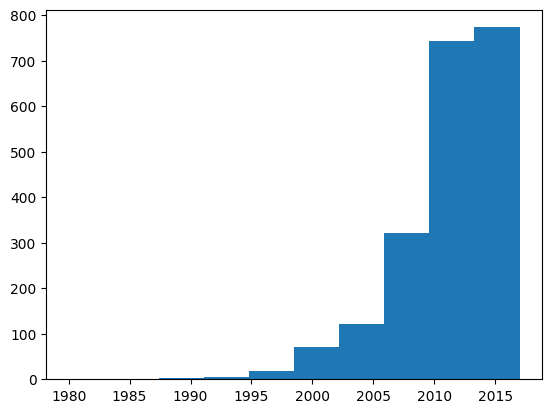

In [6]:
plt.hist(df_core["info.year"])

In [7]:
from mofdscribe.datasets.qmof_dataset import QMOFDataset

In [8]:
ds = QMOFDataset()

In [10]:
ds._df["info.year"]

0           NaN
1           NaN
2        2011.0
3        2016.0
4        2017.0
          ...  
14901       NaN
14902    1987.0
14903       NaN
14904       NaN
14905    2002.0
Name: info.year, Length: 14906, dtype: float16

(array([1.000e+00, 1.000e+00, 1.000e+00, 2.200e+01, 4.700e+01, 1.130e+02,
        1.890e+02, 1.012e+03, 3.043e+03, 1.848e+03]),
 array([1948., 1955., 1963., 1970., 1977., 1984., 1992., 1999., 2006.,
        2014., 2021.]),
 <BarContainer object of 10 artists>)

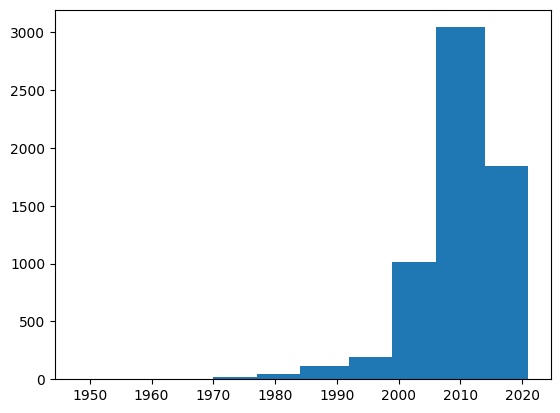

In [11]:
plt.hist(ds._df["info.year"])

In [13]:
ds._df.to_csv("../data/md-qmof.csv")

In [15]:
from mofdscribe.datasets.arcmof_dataset import ARCMOFDataset

In [16]:
arc_ds = ARCMOFDataset()

In [19]:
arc_ds._df.to_csv("../data/md-arc.csv")

In [20]:
arc_ds._df.keys()

Index(['info.undecorated_graph_hash', 'info.undecorated_no_leaf_hash',
       'info.undecorated_scaffold_hash', 'info.decorated_graph_hash',
       'info.decorated_no_leaf_hash', 'info.decorated_scaffold_hash',
       'features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-avg_bbagg-avg',
       'features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-avg_bbagg-sum',
       'features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-avg',
       'features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum',
       ...
       'outputs.landfill_gas_vpsa_wt%_working_capacity-',
       'outputs.landfill_gas_vpsa_selectivity-',
       'outputs.landfill_gas_vpsa_purity-',
       'outputs.methane_storage_psa_uptake-mmol/g',
       'outputs.methane_storage_psa_working_capacity-mmol/g',
       'outputs.methane_storage_psa_v/v_uptake-',
       'outputs.methane_storage_psa_v/v_working_capacity-',
       'outputs.methane_storage_psa_wt%_uptake-',
       'outputs.metha

In [21]:
arc_ds._df

,info.undecorated_graph_hash,info.undecorated_no_leaf_hash,info.undecorated_scaffold_hash,info.decorated_graph_hash,info.decorated_no_leaf_hash,info.decorated_scaffold_hash,features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-avg_bbagg-avg,features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-avg_bbagg-sum,features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-avg,features.racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum,...,outputs.landfill_gas_vpsa_wt%_working_capacity-,outputs.landfill_gas_vpsa_selectivity-,outputs.landfill_gas_vpsa_purity-,outputs.methane_storage_psa_uptake-mmol/g,outputs.methane_storage_psa_working_capacity-mmol/g,outputs.methane_storage_psa_v/v_uptake-,outputs.methane_storage_psa_v/v_working_capacity-,outputs.methane_storage_psa_wt%_uptake-,outputs.methane_storage_psa_wt%_working_capacity-,info.density
0,71d5da5530bdd22e546a8302c7e997a8,54842903da68cd22fb42a9637e2bb2f9,794893c6ce94e394e247b42265e9a27c,3db15d371df81d728f4918eee0e73968,cc94063c84c02708d6d45ba7928b04c1,78c769616bdd322e948bf87eedde2a4f,0.0,0.0,0.0,0.0,...,11.242188,2.021484,0.574219,31.843750,27.718750,186.500,162.375,50.937500,44.343750,0.261475
1,de813b27e5ebaf862e0fe9ed744364d5,38ead44eeb9f0af84ca25b172df31d40,38ead44eeb9f0af84ca25b172df31d40,6457442a413814678ad66d8bb22700e4,4a3f13508d80afe55b3be75f7e6de4e8,4a3f13508d80afe55b3be75f7e6de4e8,0.0,0.0,0.0,0.0,...,24.265625,3.236328,0.681641,21.281250,14.429688,243.000,164.750,34.031250,23.078125,0.509766
2,5c0fef4e26ed42defcd5504eab79b234,1e133ca6f7af57b944b610eb11e3c443,f9682098dd8477d1aae5a114df4585a1,afab51767a5b73ee4c03016ea89edf76,be921e9bdfc49091af2dc3a8618d6e85,431102c5739235fd74fda5362ce0f968,0.0,0.0,0.0,0.0,...,12.359375,3.328125,0.692383,15.296875,12.492188,200.875,164.125,24.484375,19.984375,0.585938
3,055f4b5834bb6a44211cb03c941742b9,3aeddc1b57ac0b798f275f8425cb89a5,3aeddc1b57ac0b798f275f8425cb89a5,27aa854e57971c74285e0a813bb68a54,223cc62fa004d3364d0539072307ae32,223cc62fa004d3364d0539072307ae32,0.0,0.0,0.0,0.0,...,22.296875,3.423828,0.689453,18.765625,12.148438,236.250,152.875,30.015625,19.437500,0.562012
4,44fb59787a3641ce1cdff33a5382aed1,8610525b846a67a0e52ed608dd9d44d8,ebad5e30295cbdee611f0bcfe32f13f0,94c30ab70cf654aed44b17403ca600f7,8d29663c8cb1512e0ebd06abb93f0576,819fde24dc03e76761fcbf0258551a6a,0.0,0.0,0.0,0.0,...,27.140625,3.996094,0.726562,17.359375,10.562500,238.875,145.250,27.781250,16.906250,0.613770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22447,d6c37f44eb61690dd0c9cda2c8dcfbf1,f7d51fa88b215fb45463333fadb272a7,f7d51fa88b215fb45463333fadb272a7,6e251e846d1bc5904c61ff2042877f56,dececf77dc9cddb9b8be7ecf424377f1,dececf77dc9cddb9b8be7ecf424377f1,0.0,0.0,0.0,0.0,...,13.054688,3.056641,0.672363,14.132812,10.468750,214.750,159.125,22.609375,16.750000,0.678223
22448,7e43daebe2e9827a48eb499d3bd8289a,f4ccf1bd83624c9b4c58d67df85d248a,3b16037a99643163eab06c1160c84ec3,388f3142daa04f4dcac2197f470ff035,d781fe7cc13846faa1848c5d51114439,3dbb0a649c1d0c10b17799e221dfec67,0.0,0.0,0.0,0.0,...,26.734375,4.500000,0.747070,15.234375,8.734375,231.250,132.625,24.375000,13.976562,0.677246
22449,aa201d36ea826cdcbec35c253159357b,ebad5e30295cbdee611f0bcfe32f13f0,ebad5e30295cbdee611f0bcfe32f13f0,ea478716d01d705e26d9465414f2819e,819fde24dc03e76761fcbf0258551a6a,819fde24dc03e76761fcbf0258551a6a,0.0,0.0,0.0,0.0,...,26.359375,3.669922,0.709961,18.734375,11.921875,242.000,154.000,29.984375,19.078125,0.576172
22450,324c243de533a7f39df1da3e195c3ebf,2c46431505c1b3dc8b6e2f4e3df14a58,4cf45193e86d5cef819affaba42ee5ee,6136d03d43166b222ab44f773e55fd83,24a4ddbcd0fb829ad7c78f721597b8c6,0042051f79e17cef8a7669b5d4c9ccba,0.0,0.0,0.0,0.0,...,19.250000,3.158203,0.680176,22.875000,18.015625,247.625,195.000,36.593750,28.828125,0.483154


In [36]:
df_vec = pd.read_csv("../data/fine-tune-embedding/rsm128-30.csv").set_index("type")

In [37]:
df_geo_vec = df_geo.join(df_vec)
df_racs_vec = df_racs.join(df_vec)
df_com_vec = df_com.join(df_vec)

In [38]:
df_geo_vec.to_csv("../data/features/RSM/geo_mof2vec.csv")
df_racs_vec.to_csv("../data/features/RSM/RACs_mof2vec.csv")
df_com_vec.to_csv("../data/features/RSM/stoi120_mof2vec.csv")

In [27]:
df_vec.to_csv("../data/features/RSM/mof2vec.csv")

In [41]:
df_mof2vec = pd.read_csv("../data/features/QMOF/mof2vec.csv").set_index("type")
df_stoi = pd.read_csv("../data/features/QMOF/stoich120.csv").set_index("type")

In [42]:
df_com = df_mof2vec.join(df_stoi)

In [44]:
df_com.to_csv("../data/features/QMOF/mof2vec_stoi120.csv")

In [1]:
from mofdscribe.datasets.core_dataset import CoREDataset
from mofdscribe.splitters import TimeSplitter

/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = CoREDataset()

In [3]:
spliter = TimeSplitter(ds, year_q=[0, 0.25, 1])

In [4]:
train_idx, test_idx = spliter.train_test_split(frac_train=0.9)

In [5]:
len(train_idx), len(test_idx)

(1515, 541)

In [8]:
from mofdscribe.featurizers.text.mofdscriber import MOFDescriber

In [9]:
featurizer = MOFDescriber()

In [12]:
test_structures = ds.get_structures(test_idx)

In [13]:
featurizer.featurize(test_structures[1])

Reading file /Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/robocrys/condense/mineral_db.json.gz: 0it [00:00, ?it/s]6     | 83/180 [00:00<00:00, 298.24it/s]
Decoding objects from /Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/robocrys/condense/mineral_db.json.gz: 100%|##########| 180/180 [00:00<00:00, 598.21it/s]
/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4156: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3950: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4156: 

ImportError: cannot import name 'pybel' from 'openbabel' (unknown location)

In [16]:
from mofdscribe.datasets.core_dataset import CoREDataset
import shutil
import os

In [3]:
ds = CoREDataset()

In [6]:
df = ds._df.copy()

In [12]:
md_path = "/Users/xiaoqi/.data/mofdscribe/CoRE/v0.0.1/structures/"

In [104]:
year = 2018
names = df[df["info.year"] == year]["info.name"].values

In [105]:
len(names)

0

In [103]:
path = "../data/cifs/md_%s" %year
os.mkdir(path)
for name in names:
    shutil.copyfile(
        os.path.join(md_path, name+".cif"),
        os.path.join(path, name+".cif")
    )